In [1]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from scipy.io import savemat #for save obspy object as matlab format

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

In [4]:
#2017-4-3T17:40:18
t = UTCDateTime(2017, 4, 3, 17, 40, 18)
lon = 25.1558
lat = -22.6784

In [5]:
client = Client("IRIS")
inventory = client.get_stations(
    starttime=t-180, endtime=t+180,
    longitude=lon, latitude=lat, maxradius=10,
    matchtimeseries=None)
#print(inventory)

Inventory created at 2022-06-02T09:10:40.768000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2017-04-03...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (8):
			8A, AF, GE, GT, IU, NR, SY, ZT
		Stations (180):
			8A.BAHE (Namibia)
			8A.GAMM (Namibia)
			8A.HELM (Namibia)
			8A.HOCH (Namibia)
			8A.KANO (Namibia)
			8A.NEPA (Namibia)
			8A.OKAM (Namibia)
			8A.OMUT (Namibia)
			8A.OTJO (Namibia)
			8A.WEWE (Namibia)
			AF.BLWY (Bulawayo, Zimbabwe)
			AF.CNG (Changalane Maputo Province Mozambique)
			AF.CRLN (Carolina, Mapumpalanga, South Africa)
			AF.HVD (Gariep Dam CMG-40T Earth data Low gain)
			AF.MONG (Mongu, Zambia, Africa)
			AF.MOPA (Mopani Camp, Kruger National Park, RSA)
			AF.MUSN (Musina, Limpopo, South Africa)
			AF.PKA (Prieska CMG-40T Earth data Low gain)
			AF.POGA (Pongola, Kwazulu-Natal, South Africa)
			AF.RUDU (Rundu, Ovamboland, Namibia)
			AF.SNKL (Senekal, Freesta

In [ ]:
inv2 = client.get_stations(starttime=t-180, endtime=t+180,
    minlatitude=lat-2,
    maxlatitude=lat+2,
    minlongitude=lon-2,
    maxlongitude=lon+2,network="NR",
    matchtimeseries=None)
print(inv2)
net = inv2
net.plot(projection="local");  

In [6]:
station_list = ["NE208","NE212"] #NE201 NE209 NE220 No data 

In [7]:
for sta in station_list:
    print(sta)

NE208
NE212


In [ ]:
def get_data_from_iris(t0, net, st0, loc, ch, duration):
    """
    Download data for a station from IRIS.

    Download data from the IRIS datacenter and output
    with the instrument response removed and calibrated.
    A filter is also placed. Return a station object.
    """
    client = Client('IRIS')
    st = client.get_waveforms(net, st0, loc, ch, t0,
                              t0+duration*60, attach_response=True)
    st.detrend(type='demean')
    st.detrend(type='linear')
    st.taper(max_percentage=0.05)
    st.remove_response(output='DISP')
    st.filter('highpass', freq=0.01, corners=4, zerophase=True)
    return st

In [48]:
sta = "NE208"
st = client.get_waveforms(network="NR", station=sta, location="", channel="BH?", starttime=t-10, endtime=t+50)
st.detrend(type='demean')
st.detrend(type='linear')
st.taper(max_percentage=0.05)

3 Trace(s) in Stream:
NR.NE208..BHE | 2017-04-03T17:40:08.048800Z - 2017-04-03T17:41:07.998800Z | 20.0 Hz, 1200 samples
NR.NE208..BHN | 2017-04-03T17:40:08.048800Z - 2017-04-03T17:41:07.998800Z | 20.0 Hz, 1200 samples
NR.NE208..BHZ | 2017-04-03T17:40:08.048800Z - 2017-04-03T17:41:07.998800Z | 20.0 Hz, 1200 samples

AttributeError: 'function' object has no attribute 'remove_response'

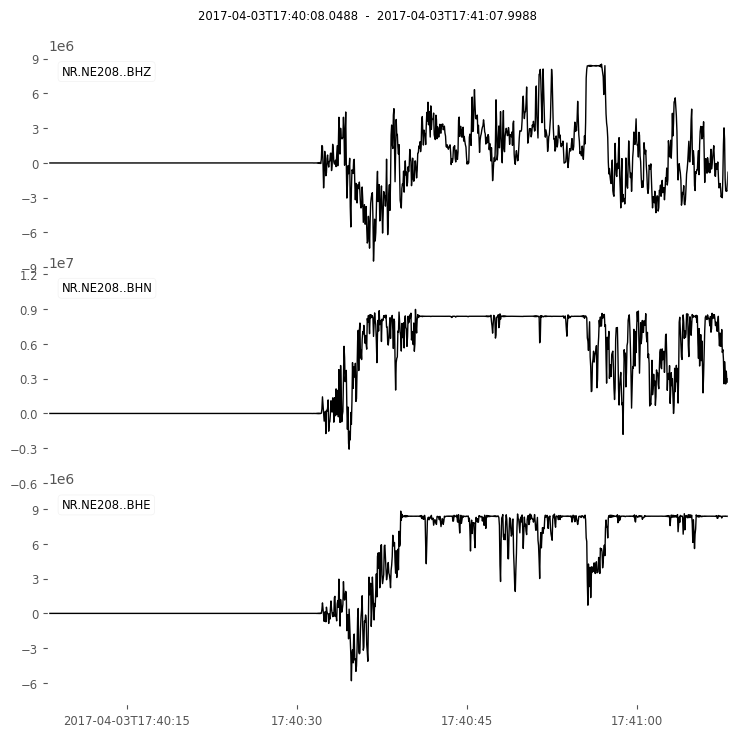

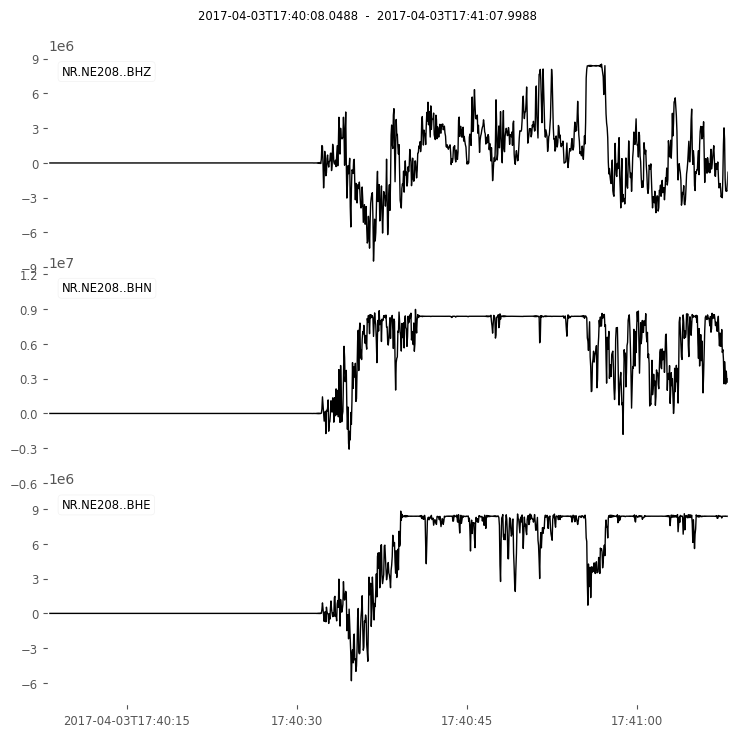

In [38]:
st.plot();


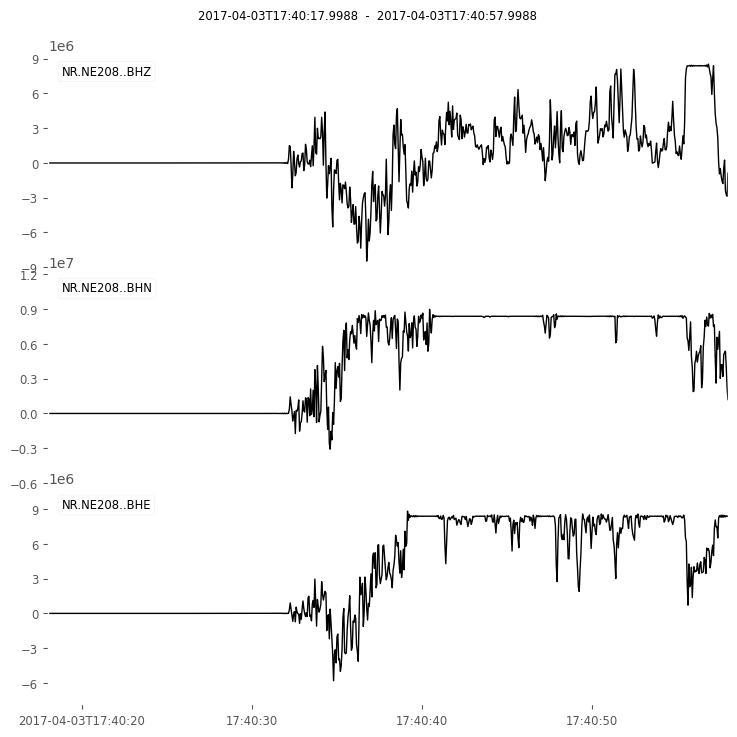

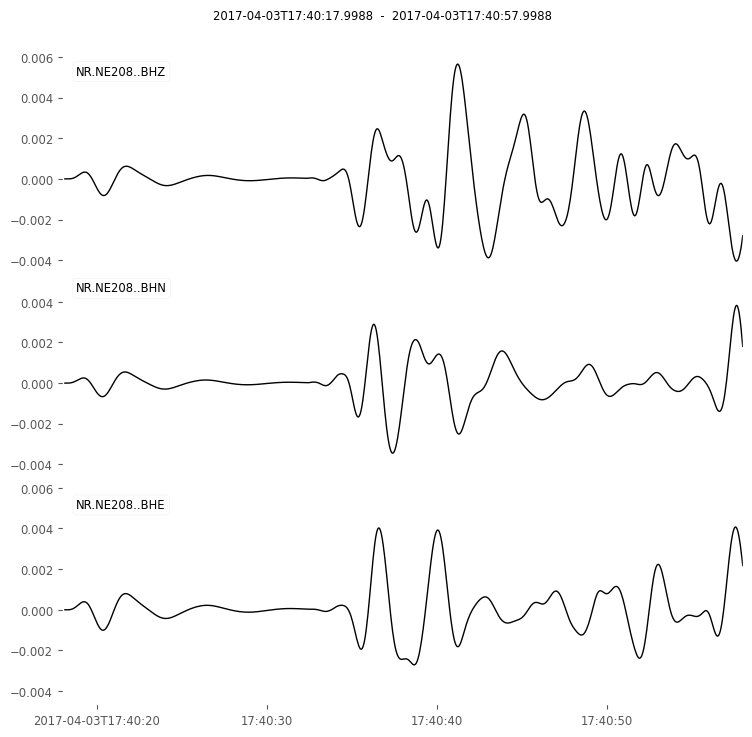

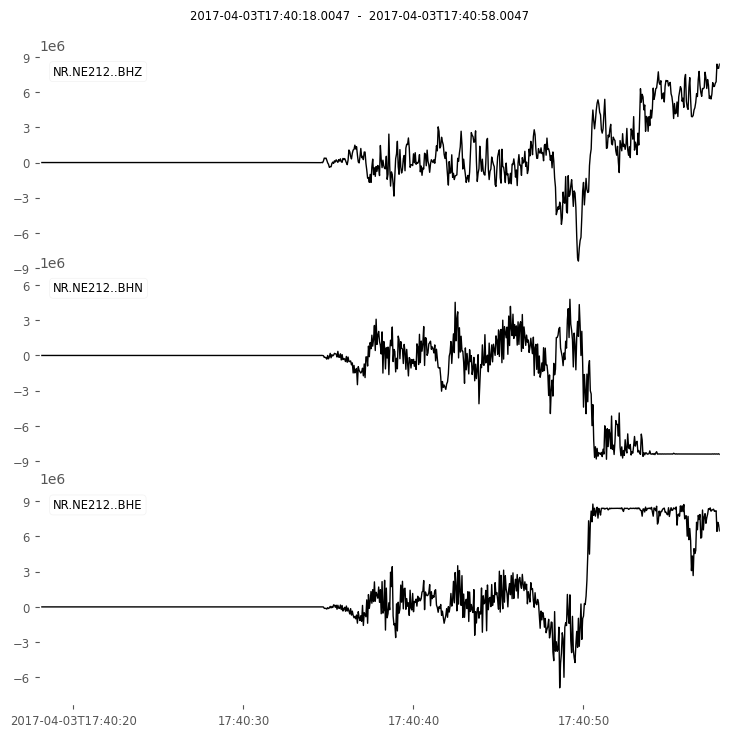

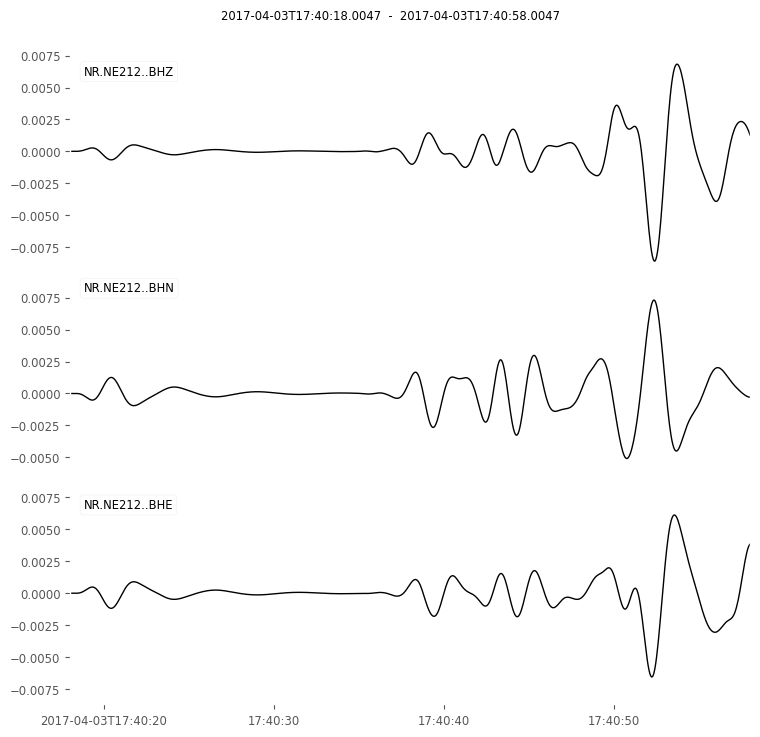

In [63]:
for sta in station_list:
    #request 1 minuate data
    st = client.get_waveforms(network="NR", station=sta, location="", channel="BH?", starttime=t-10, endtime=t+50)
    #cut it in 40 sec
    st1=st.slice(starttime=t, endtime=t+40)
    st1.plot();#Plot RAW data
    #get instrument response
    inv = client.get_stations(network="NR", station=sta, location="", channel="BH?",
                     starttime=t, endtime=t+40, level="response")
    #instrument removed + filter[bandpass, 0.2-0,6]
    st2 = st1.copy()
    st2.detrend(type='demean')
    st2.detrend(type='linear')
    st2 = st2.remove_response(inventory=inv).filter("bandpass", freqmin=0.2, freqmax=0.6, corners=4);
    st2.plot();
    for i, tr in enumerate(st2):
        mdict = {k: str(v) for k, v in tr.stats.items()} #change iteritems to items
        mdict['data'] = tr.data
        savemat("data-" + str(sta) + "_" + str(i) +".mat", mdict) #change like this
   

In [56]:
st2

3 Trace(s) in Stream:
NR.NE212..BHE | 2017-04-03T17:40:18.004700Z - 2017-04-03T17:40:58.004700Z | 20.0 Hz, 801 samples
NR.NE212..BHN | 2017-04-03T17:40:18.004700Z - 2017-04-03T17:40:58.004700Z | 20.0 Hz, 801 samples
NR.NE212..BHZ | 2017-04-03T17:40:18.004700Z - 2017-04-03T17:40:58.004700Z | 20.0 Hz, 801 samples

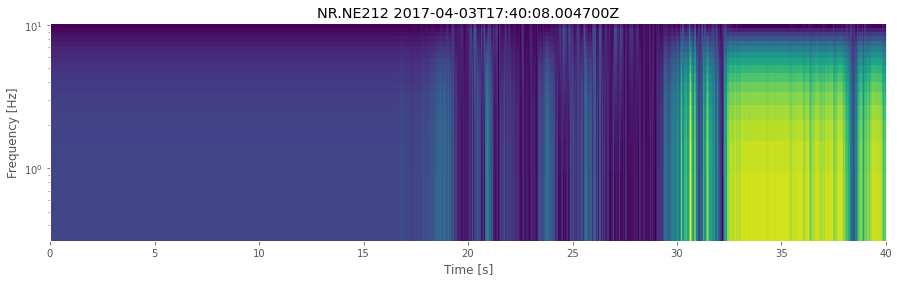

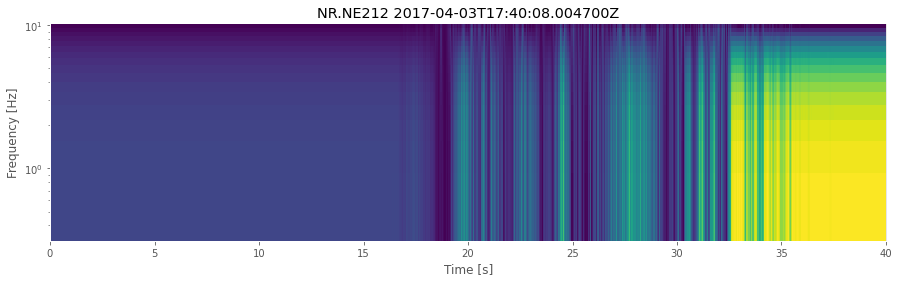

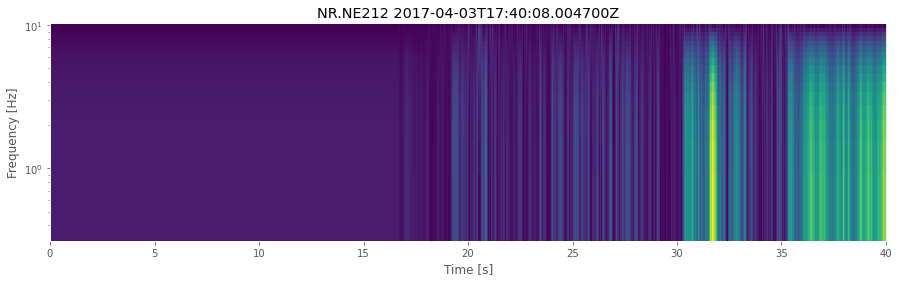

[None, None, None]

In [59]:
st1.spectrogram(log=True, title='NR.NE212 ' + str(st[0].stats.starttime))